In [1]:
import sys

sys.path.insert(0, "../..")

%load_ext autoreload
%autoreload 2

(sgpr_heteroskedastic)=

# SGPR regression with heteroskedastic noise

In [2]:
from jax.config import config

config.update("jax_debug_nans", True)
import jax
import copy
import jaxgp as jgp
import jax.numpy as jnp
from jaxgp.sgpr_heteroskedastic import HeteroskedasticSGPR
import jaxopt
import numpy as np
import matplotlib.pyplot as plt

/Users/lichengk/.miniforge3/envs/py39_forge/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [19]:
rng = np.random.RandomState(123)


def readCsvFile(fileName):
    return np.loadtxt(fileName).reshape(-1, 1)


def getTrainingTestData():
    overallX = readCsvFile("data/snelson_train_inputs.dat")
    overallY = readCsvFile("data/snelson_train_outputs.dat")

    trainIndices = []
    testIndices = []

    nPoints = overallX.shape[0]

    for index in range(nPoints):
        if index % 4 == 0:
            trainIndices.append(index)
        else:
            testIndices.append(index)

    Xtrain = overallX[trainIndices, :]
    Xtest = overallX[testIndices, :]
    Ytrain = overallY[trainIndices, :]
    Ytest = overallY[testIndices, :]

    return Xtrain, Ytrain, Xtest, Ytest


X, y, Xtest, ytest = getTrainingTestData()
inds = jnp.argsort(X[:,0])
X = X[inds]
y = y[inds]
Z = X.copy()

## Sanity check with SGPR with homoscedastic noise

In [ ]:
train_data = jgp.Dataset(X=X, Y=y)
kernel = jgp.kernels.RBF(active_dims=jnp.arange(X.shape[-1]))
model = HeteroskedasticSGPR(
    train_data=train_data,
    gprior=jgp.GPrior(kernel=kernel),
    likelihood=jgp.likelihoods.HeteroskedasticGaussian(user_provided=True),
    sigma_sq=jnp.ones(X.shape[0]) * 0.07428594,
    inducing_points=Z,
)

params, constrain_trans, unconstrain_trans = jgp.initialise(model)

In [ ]:
# print params' shape info
params_container = copy.deepcopy(params)
params_container = jax.tree_map(lambda v: v.shape, params_container)
print(params_container)

In [ ]:
raw_params = unconstrain_trans(params)
neg_elbo = model.build_elbo(sign=-1.0)
print("Initial negative elbo = ", neg_elbo(raw_params))
solver = jaxopt.ScipyMinimize(fun=neg_elbo, jit=True, options={"disp": True})
soln = solver.run(raw_params)
# Remember to transform since the optimization is in unconstrained space
final_params = constrain_trans(soln.params)
print("After optimization negative elbo = ", neg_elbo(soln.params))

posterior = model.posterior()

In [ ]:
Xtest = jnp.linspace(-3, 10, 100)
pred_mean, pred_var = posterior.predict_f(Xtest, final_params, full_cov=False)
plt.plot(X, y, "o", color="k", markersize=2)
plt.plot(
    final_params["inducing_points"], np.zeros_like(Z), "x", color="tab:red"
)
plt.plot(Xtest, pred_mean, color="tab:orange", linewidth=2)
plt.fill_between(
    Xtest.squeeze(),
    pred_mean.squeeze() - 2 * np.sqrt(pred_var.squeeze()),
    pred_mean.squeeze() + 2 * np.sqrt(pred_var.squeeze()),
    alpha=0.5,
    color="tab:blue",
)

In [ ]:
qu_mean, qu_cov = model.compute_qu(final_params)
f_at_Z_mean, f_at_Z_cov = posterior.predict_f(
    final_params["inducing_points"], final_params, full_cov=True
)
assert jnp.allclose(qu_mean, f_at_Z_mean, rtol=1e-5, atol=1e-4)
assert jnp.allclose(
    qu_cov.reshape(1, 50, 50), f_at_Z_cov, rtol=1e-5, atol=1e-5
)

## Heteroskedastic noise

In [20]:
train_data = jgp.Dataset(X=X, Y=y)
kernel = jgp.kernels.RBF(active_dims=jnp.arange(X.shape[-1]))
model = HeteroskedasticSGPR(
    train_data=train_data,
    gprior=jgp.GPrior(kernel=kernel),
    likelihood=jgp.likelihoods.HeteroskedasticGaussian(user_provided=True),
    # sigma_sq=jnp.linspace(0.1, 10., X.shape[0]),
    sigma_sq=jnp.concatenate([0.01 * jnp.ones(X.shape[0] // 2), 1. * jnp.ones(X.shape[0] -X.shape[0] // 2)]),
    inducing_points=Z,
)

params, constrain_trans, unconstrain_trans = jgp.initialise(model)
raw_params = unconstrain_trans(params)
neg_elbo = model.build_elbo(sign=-1.0)
print("Initial negative elbo = ", neg_elbo(raw_params))
solver = jaxopt.ScipyMinimize(fun=neg_elbo, jit=True, options={"disp": True})
soln = solver.run(raw_params)
# Remember to transform since the optimization is in unconstrained space
final_params = constrain_trans(soln.params)
print("After optimization negative elbo = ", neg_elbo(soln.params))

posterior = model.posterior()

Initial negative elbo =  91.49178283806722
Optimization terminated successfully.
         Current function value: 75.785264
         Iterations: 100
         Function evaluations: 101
         Gradient evaluations: 101
After optimization negative elbo =  75.78526441489558


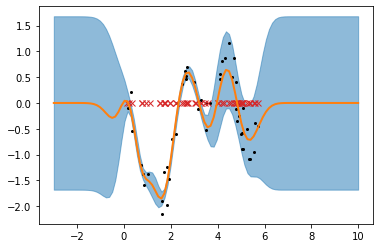

In [21]:
Xtest = jnp.linspace(-3, 10, 100)
pred_mean, pred_var = posterior.predict_f(Xtest, final_params, full_cov=False)
plt.plot(X, y, "o", color="k", markersize=2)
plt.plot(
    final_params["inducing_points"], np.zeros_like(Z), "x", color="tab:red"
)
plt.plot(Xtest, pred_mean, color="tab:orange", linewidth=2)
plt.fill_between(
    Xtest.squeeze(),
    pred_mean.squeeze() - 2 * np.sqrt(pred_var.squeeze()),
    pred_mean.squeeze() + 2 * np.sqrt(pred_var.squeeze()),
    alpha=0.5,
    color="tab:blue",
)